In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [37]:
df=pd.read_csv(r'Irish_DataSet\finalDataForResidential.txt',header=None,delimiter=" ")
df.rename(columns={0: "ID", 1: "Month", 2: "Time", 3: "Consumption"},inplace=True)
def convert_date(day):
    base_date = datetime(2009, 1, 1)
    converted_date = base_date + timedelta(days=(day - 195))
    return converted_date

def convert_time(time):
    hours = (time - 1) // 2
    minutes = (time - 1) % 2 * 30
    return f"{(hours):02d}:{(minutes):02d}"

df.set_index("ID", inplace=True)
df['Month'] = df['Month'].apply(convert_date)
df

,Month,Time,Consumption
ID,,,
1002,2009-01-01,1,0.362
1002,2009-01-01,2,0.064
1002,2009-01-01,3,0.119
1002,2009-01-01,4,0.023
1002,2009-01-01,5,0.140
...,...,...,...
1998,2009-06-20,46,1.242
1998,2009-06-20,47,2.724
1998,2009-06-20,48,1.853


In [42]:
df.isnull().sum()
# df['Time'] = df['Time'].apply(convert_time)

Month          0
Time           0
Consumption    0
dtype: int64

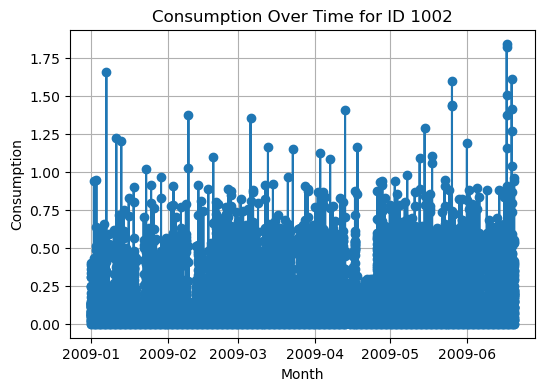

In [76]:
id_1002 = df[df.index == 1002]

# Plot the "Consumption" column over time
plt.figure(figsize=(6, 4))  
plt.plot(id_1002["Month"], id_1002["Consumption"], marker='o', linestyle='-')
plt.title("Consumption Over Time for ID 1002")
plt.xlabel("Month")
plt.ylabel("Consumption")
plt.grid(True)
plt.show()

In [57]:
data = df.groupby(['ID', 'Month'])['Consumption'].sum().reset_index()
data.rename(columns={'Consumption': 'DailyConsumption'}, inplace=True)
data.set_index("ID", inplace=True)
data

,Month,DailyConsumption
ID,,
1002,2009-01-01,6.355
1002,2009-01-02,8.972
1002,2009-01-03,8.794
1002,2009-01-04,8.306
1002,2009-01-05,10.119
...,...,...
1998,2009-06-16,27.896
1998,2009-06-17,34.113
1998,2009-06-18,33.227


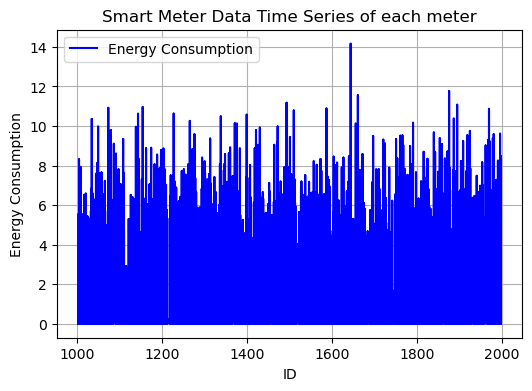

In [79]:
plt.figure(figsize=(6, 4))  # Set the figure size
plt.plot(df.index, df['Consumption'], label='Energy Consumption', color='blue')
plt.title('Smart Meter Data Time Series of each meter')
plt.xlabel('ID')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

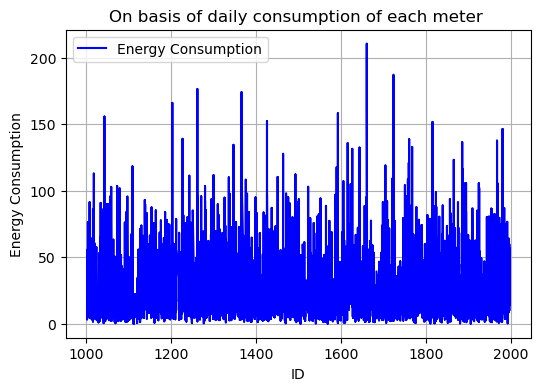

In [81]:
plt.figure(figsize=(6,4))
plt.plot(data.index, data['DailyConsumption'], label='Energy Consumption', color='blue')
plt.title('On basis of daily consumption of each meter ')
plt.xlabel('ID')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

## Standardizing the data

In [61]:
scaler = StandardScaler()
X_std = scaler.fit_transform(data[['DailyConsumption']].values)

## find K using Elblow method 

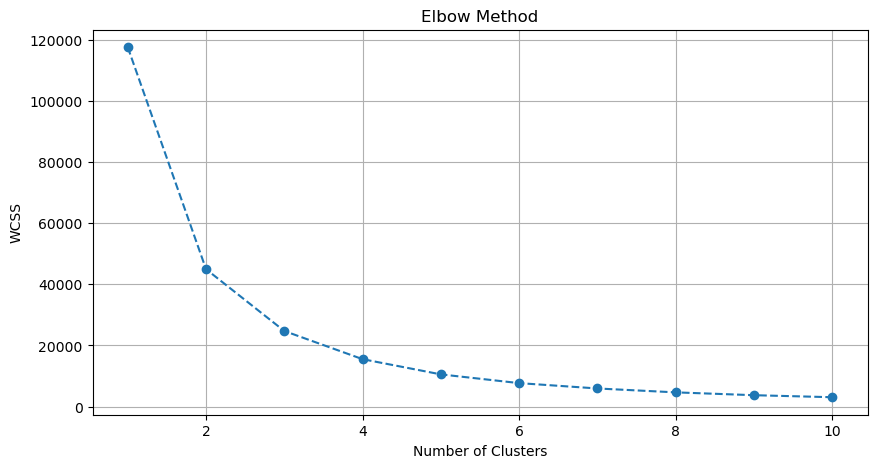

In [64]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_std)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

## K-means clustering

In [65]:
##without train and test 
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10,max_iter=100)
kmeans.fit(X_std)

KMeans(max_iter=100, n_clusters=4, n_init=10, random_state=42)

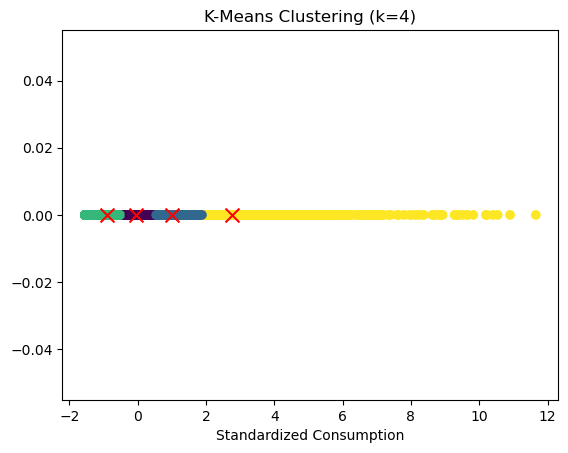

In [66]:
plt.scatter(X_std[:,], [0] * len(X_std), c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,], [0] * len(kmeans.cluster_centers_), c='red', marker='x', s=100)
plt.xlabel('Standardized Consumption')
plt.title(f'K-Means Clustering (k={k})')
plt.show()

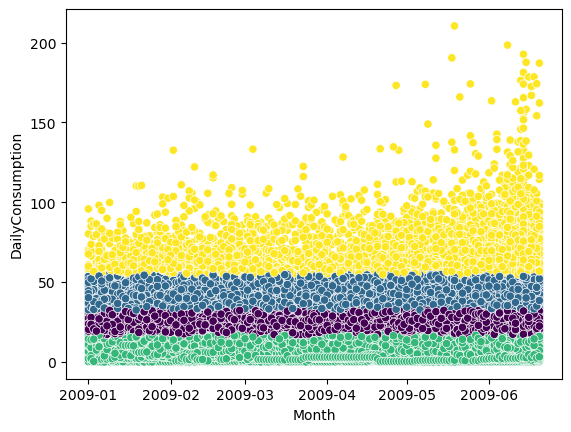

In [71]:
cluster_labels = kmeans.labels_
data['Cluster'] = cluster_labels

sns.scatterplot(data=data, x='Month', y='DailyConsumption', hue='Cluster', palette='viridis', legend=False)
plt.show()
# print("Length of cluster_labels:", len(cluster_labels))

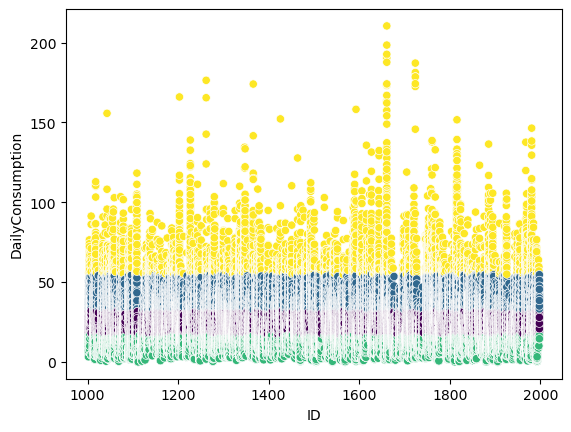

In [72]:
sns.scatterplot(data=data, x='ID', y='DailyConsumption', hue='Cluster', palette='viridis', legend=False)
plt.show()

In [ ]:
sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0,n_init=10,max_iter=100)
    cluster_labels = kmeans.fit_predict(data[['DailyConsumption']])
    silhouette_avg = silhouette_score(data[['DailyConsumption']], cluster_labels)
    sil_scores.append(silhouette_avg)

plt.plot(range(2, 11), sil_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
chosen_k =  4
kmeans = KMeans(n_clusters=chosen_k, random_state=0)
data['cluster'] = kmeans.fit_predict(data[['DailyConsumption']])

plt.scatter(data['ID'], data['DailyConsumption'], c=data['cluster'])
plt.title('K-Means Clustering (k={})'.format(chosen_k))
plt.xlabel('ID')
plt.ylabel('DailyConsumption')
plt.show()

## Training and Testing dataset 

In [7]:
X = df.drop('Consumption', axis=1)  # Features
y = df['Consumption']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4699080, 3), (1174770, 3), (4699080,), (1174770,))

## Standardize the features:

In [14]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## Train K-means clustering model with the chosen number of clusters

In [34]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_train_std)

# Predict clusters for the test data
y_pred = kmeans.predict(X_test_std)

## Evaluate the accuracy of the K-means clustering model:

In [39]:
silhouette_avg = silhouette_score(X_test_std, y_pred)

# cluster_labels = kmeans.labels_
# silhouette_avg = silhouette_score(X_train_std, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.2f}')

#A higher silhouette score indicates better clustering

In [37]:
inertia = kmeans.inertia_
print(f'Inertia (within-cluster sum of squares): {inertia:.2f}')

Inertia (within-cluster sum of squares): 5621774.76
